In [1]:
%matplotlib inline

import pandas as pd
import itertools
import pickle
import networkx as nx
import community as cm
import numpy as np
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import seaborn

We store all the users in an array on which we will work.

In [2]:
#get users
users = pickle.load(open('users.p', 'rb'))

# Cleaning

We extract all the Swiss cities on the Wikipedia page "List of cities in Switzerland"

In [5]:
url = 'https://en.wikipedia.org/wiki/List_of_cities_in_Switzerland'
r = requests.get(url)
soup = BeautifulSoup(r.content,"lxml")

In [6]:
switzerland_places = set()

for i in range(2,260) :
    switzerland_places.add(soup.findAll('table')[1].findAll('tr')[i].findAll('a')[0].next)

All the Swiss cities are stored in an array switerland_places.(Example with the first 20 elements)

In [7]:
list(switzerland_places)[0:20]

['Monthey',
 'Carouge (GE)',
 'Baden',
 'Liestal',
 'Moudon',
 'Schaffhausen',
 'Arbon',
 'Mendrisio',
 'Prilly',
 'Cham',
 'Échallens',
 'Klingnau',
 'Bad Zurzach',
 'Gossau (SG)',
 'Montreux',
 'Stans',
 'Beromünster',
 'Walenstadt',
 'Oftringen',
 'Mellingen']

We add manually the translations,cities and places (ex: CERN) that were not on the wikipedia page.

In [8]:
switzerland_places |= set(['Switzerland','Suisse','Schweiz','Luzern','Gümligen','Ecublens','Svizzera','Swiss','Zurich',
                          'Flamatt','Echarlens','St.Gallen','CERN','Niederrohrdorf','Laupersdorf','Cartigny','Renens','Geneve'])

In [9]:
#Return true if the location is in Switzerland, false otherwise.
def check_switzerland(location) :
    
    if 'CH' in str(location) or 'ch' == str(location).lower() or 'zh' == str(location).lower() : 
        return True
    
    for place in switzerland_places :        
        if place.lower() in str(location).lower() :            
            return True        
    
    return False    

# Collaboration graph and communities

We create a dictionary users_repos in which the keys represent the users ID, and the values are the list of the users' repos.

In [10]:
users_repos = {}

for user in users :    
    if(check_switzerland(user['location'])) :        
        repos = []
        
        for rep in user['repositories_docs'] : 
            
            if(rep['name'] != 'gitignore') :
                repos.append((rep['name'],rep['language']))
    
        users_repos[user['_id']] = repos

Example with a certain user :

We create the edges of our graph: two users are neighbors if they both work on the same repo. We should be careful that the intersection of the repos (the set common_repos) doesn't contain only "gitignore".

In [11]:
edges = []

#Plus rapide d'iterer sur valid_users que sur les clés des dictionnaires directement pour eviter de créer des edges identiques
valid_users = list(users_repos.keys())

for i in range(0,len(valid_users)-1) :
    for j in range(i+1,len(valid_users)) : 
        common_repos = set(users_repos[valid_users[i]]).intersection(users_repos[valid_users[j]])
        
        if(len(common_repos))>0 :                
                edges.append((valid_users[i],valid_users[j]))

We create the graph with the library NetworkX from the list of edges created in the previous cell and we use the draw method to display it.

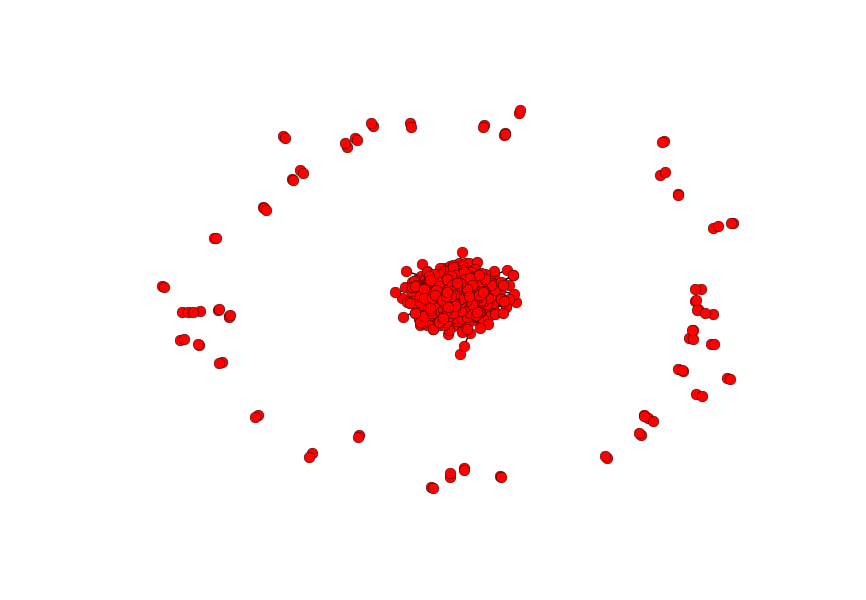

In [12]:
graph = nx.Graph()
graph.add_edges_from(edges)

nx.draw(graph,pos=nx.spring_layout(graph),node_size=60)

We now use the library community which uses the Louvain algorithm to find the best communities in the graph. The result is stored in the form of a "partition" dictionary in which the keys are the users and the values are integers representing the communities to which the users belong.

In [14]:
partition = cm.best_partition(graph)
partition

{1253376: 0,
 1032193: 1,
 4549666: 3,
 819203: 2,
 9445381: 3,
 65542: 4,
 196617: 5,
 843787: 1,
 1974284: 4,
 3530769: 6,
 98322: 4,
 9797652: 7,
 316761: 1,
 426015: 1,
 5504279: 8,
 507938: 0,
 10280998: 8,
 3481639: 1,
 41003: 1,
 1146924: 5,
 950321: 9,
 373437: 1,
 1794099: 10,
 2203704: 7,
 16302137: 6,
 434236: 4,
 2629695: 7,
 213059: 1,
 3309637: 1,
 14975048: 11,
 385036: 1,
 1318986: 6,
 4456527: 12,
 278609: 6,
 4852006: 12,
 6389844: 3,
 2621526: 1,
 14270552: 6,
 7779684: 6,
 3489883: 0,
 1286236: 4,
 57439: 8,
 196704: 1,
 8298593: 1,
 6242406: 1,
 3111088: 1,
 32876: 0,
 1400944: 3,
 901234: 1,
 2580598: 1,
 1073273: 3,
 6758523: 1,
 1597565: 13,
 49278: 1,
 966785: 10,
 2146436: 1,
 4145285: 3,
 5259398: 13,
 196746: 3,
 1573003: 14,
 11690126: 1,
 254096: 1,
 1466515: 15,
 8461: 8,
 475285: 16,
 82070: 15,
 278680: 1,
 549018: 3,
 573595: 1,
 163996: 1,
 1089693: 5,
 3055774: 1,
 368799: 15,
 860323: 17,
 721063: 6,
 745643: 7,
 1204400: 1,
 2719922: 8,
 12279988: 

We now count how many users there are in each communitiy:

In [15]:
number_partitions = {}

for u in partition :
    if partition[u] not in number_partitions.keys() :        
        number_partitions[partition[u]] =0        
    number_partitions[partition[u]]+=1

number_partitions

{0: 261,
 1: 985,
 2: 137,
 3: 553,
 4: 257,
 5: 185,
 6: 173,
 7: 145,
 8: 132,
 9: 122,
 10: 114,
 11: 2,
 12: 124,
 13: 125,
 14: 2,
 15: 169,
 16: 2,
 17: 2,
 18: 74,
 19: 2,
 20: 2,
 21: 3,
 22: 12,
 23: 2,
 24: 2,
 25: 2,
 26: 2,
 27: 3,
 28: 3,
 29: 2,
 30: 2,
 31: 2,
 32: 4,
 33: 2,
 34: 2,
 35: 2,
 36: 2,
 37: 2,
 38: 2,
 39: 2,
 40: 3,
 41: 2,
 42: 2,
 43: 2,
 44: 2,
 45: 2,
 46: 2,
 47: 2,
 48: 2,
 49: 2,
 50: 2,
 51: 2,
 52: 4,
 53: 5,
 54: 2,
 55: 2,
 56: 2,
 57: 2,
 58: 2,
 59: 2,
 60: 2,
 61: 2,
 62: 2}

We can consider that a graph a structure of signicative communities when a partition obtains a modularity score greater than 0,3. In our case we obtain 0.565; Hence, the graph has a structure of significative communities.

In [16]:
cm.modularity(partition,graph)

0.5653149302217744

We notice that there are some big communities and other very small (composed by 2 to 4 vertices). As we have seen on the drawing of the graph, there is a huge component but also many small and disconnected components. It is because of the latter that there are many small communities. In the rest of the analysis, we will ignore those small communities to focus on the bigger ones (size > 70).
Moreover, we can highlight the communities with some examples. (We only draw the subgraphs because an entire graph isn't clear).


In [17]:
interesting_communities = [key for key in number_partitions.keys() if number_partitions[key] > 70]

In [18]:
#On va dessiner le graphe sans les vertices qui sont ininteressants : 
vertices_to_remove = []
community_nodes = {key : [] for key in interesting_communities}


for v in partition : 
    if partition[v] not in interesting_communities : 
        vertices_to_remove.append(v)    
    else :        
        community_nodes[partition[v]].append(v)        

In [19]:
val_map = { community : (i+1)/len(interesting_communities) for community,i in enumerate(interesting_communities)}

Communities  0  and  8  : 


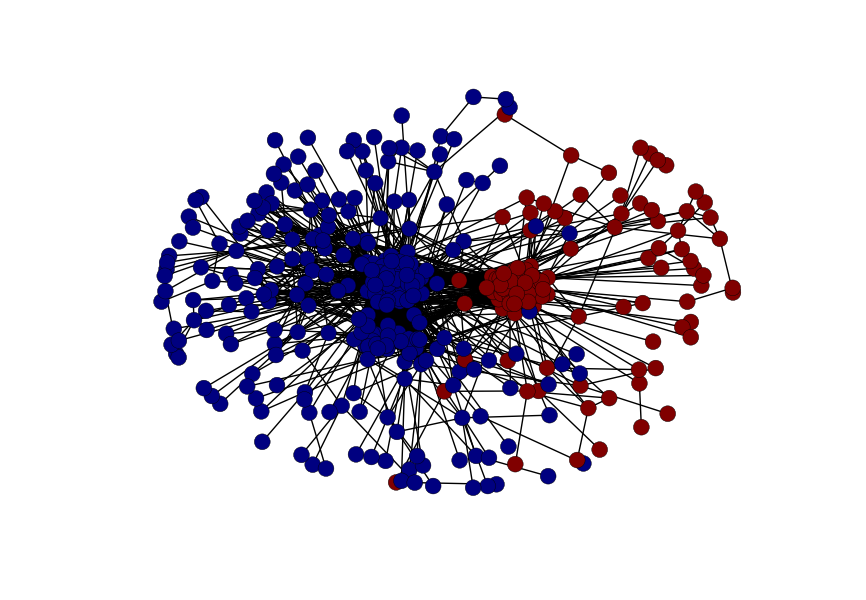


Communities  2  and  3  : 


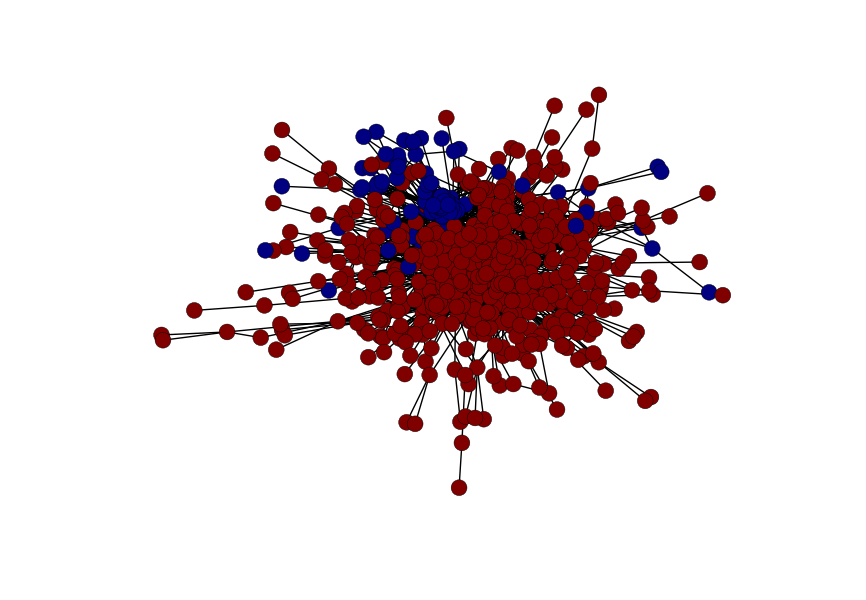


Communities  5  and  6  : 


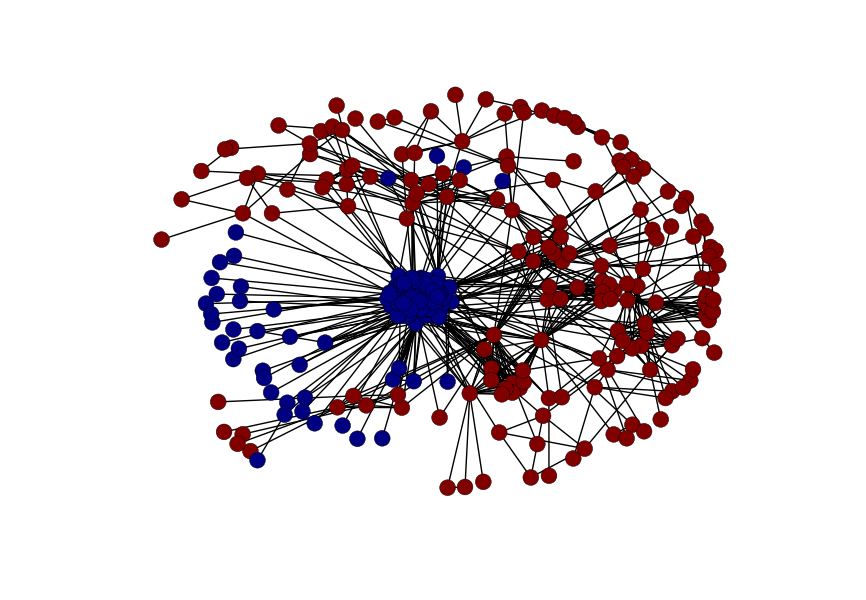


Communities  9  and  10  : 


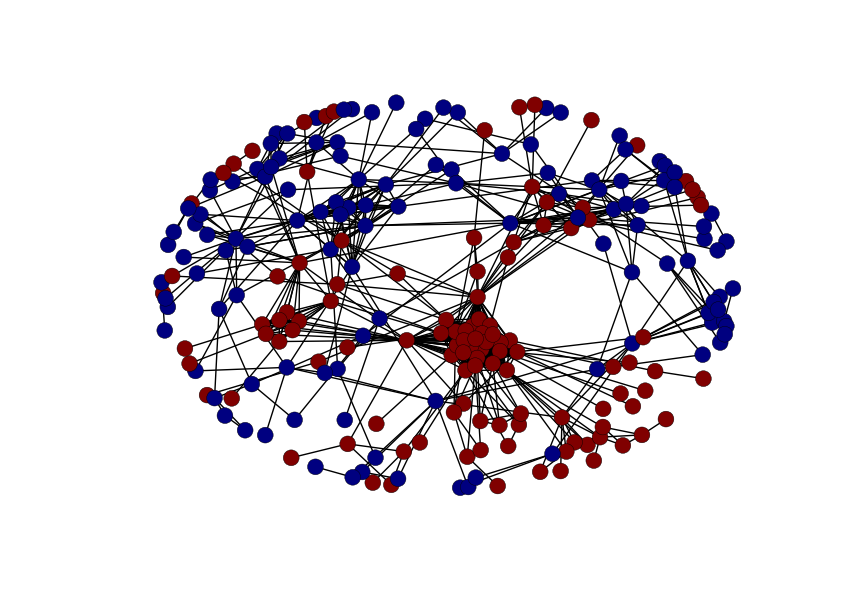

In [20]:
for i,j in [(0,8),(2,3),(5,6),(9,10)] : 
    
    print('Communities ',i,' and ',j, ' : ')

    subgraph = graph.subgraph(community_nodes[i]+community_nodes[j])
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph,pos=nx.spring_layout(subgraph),node_size=130,cmap=plt.get_cmap('jet'),
                 node_color=[val_map.get(partition[node]) for node in subgraph.nodes()])

    plt.show()
    
    print()

## Study of the different programming languages

In [21]:
for community in interesting_communities :
    
    counts = {}

    for user in users :       
        if(partition.get(user['_id']) == community) :        
            for repo in user['repositories_docs']:
                if repo['language'] not in counts:
                    counts[repo['language']] = 0
                counts[repo['language']] += 1
                
    data = [{ 'language': lang, 'count': counts[lang] } for lang in counts]
    df = pd.DataFrame(data).set_index('language') 
    most_used_languages = list(df.sort_values(by='count', ascending=False)[0:3].index)
    
    if None in most_used_languages : 
        most_used_languages.remove(None)
        
    print('Most used languages for community ',community, ' : ')
    print()
    print('1) ', most_used_languages[0])
    print('2) ', most_used_languages[1])

Most used languages for community  0  : 

1)  JavaScript
2)  Python
Most used languages for community  1  : 

1)  JavaScript
2)  Python
Most used languages for community  2  : 

1)  R
2)  Python
Most used languages for community  3  : 

1)  PHP
2)  Python
Most used languages for community  4  : 

1)  Scala
2)  Java
Most used languages for community  5  : 

1)  Python
2)  JavaScript
Most used languages for community  6  : 

1)  Java
2)  JavaScript
Most used languages for community  7  : 

1)  JavaScript
2)  Java
Most used languages for community  8  : 

1)  JavaScript
2)  Python
Most used languages for community  9  : 

1)  C++
2)  Python
Most used languages for community  10  : 

1)  JavaScript
2)  Java
Most used languages for community  12  : 

1)  C++
2)  Python
Most used languages for community  13  : 

1)  Objective-C
2)  JavaScript
Most used languages for community  15  : 

1)  JavaScript
2)  Python
Most used languages for community  18  : 

1)  Java
2)  JavaScript


### Geographical study

In [22]:
for community in interesting_communities :
    
    counts = {}

    for user in users :       
        if(partition.get(user['_id']) == community) :        
            if user['location'] not in counts:
                counts[user['location']] = 0
            counts[user['location']] += 1 
            

    
    data = [{ 'location': loc, 'count': counts[loc] } for loc in counts]
    df = pd.DataFrame(data).set_index('location') 
    locations = list(df.sort_values(by='count', ascending=False)[0:5].index)
    
    if None in most_used_languages : 
        most_used_languages.remove(None)
        
    print('Locations for community ',community, ' : ')
    print()
    print('1) ', locations[1])
    print('2) ', locations[2])
    print('3) ', locations[3])
    print()

Locations for community  0  : 

1)  Zurich, Switzerland
2)  Zürich, Switzerland
3)  Zurich

Locations for community  1  : 

1)  Zurich, Switzerland
2)  Zürich, Switzerland
3)  Zurich

Locations for community  2  : 

1)  Lausanne, Switzerland
2)  Zurich, Switzerland
3)  Geneva

Locations for community  3  : 

1)  Zurich, Switzerland
2)  Zürich, Switzerland
3)  Lausanne, Switzerland

Locations for community  4  : 

1)  Lausanne, Switzerland
2)  Zurich, Switzerland
3)  Zürich, Switzerland

Locations for community  5  : 

1)  Zurich, Switzerland
2)  Zürich, Switzerland
3)  Zurich

Locations for community  6  : 

1)  Zurich, Switzerland
2)  Suisse
3)  Lausanne, Switzerland

Locations for community  7  : 

1)  Zurich, Switzerland
2)  Zurich
3)  Zürich, Switzerland

Locations for community  8  : 

1)  Zurich
2)  Suisse
3)  Geneva

Locations for community  9  : 

1)  Zurich, Switzerland
2)  Zurich
3)  Lausanne, Switzerland

Locations for community  10  : 

1)  Zurich, Switzerland
2)  Zurich
3)

### Statistical study of the repositories by community

We begin by creating a dataframe named repos_informations where we stock all the informations about the repositories on which we will conduct a statistical study.

In [23]:
temp = []

for user in users :        
    for repo in user['repositories_docs'] :
        
        if partition.get(user['_id']) in interesting_communities and repo['name'] != 'gitignore' : 
            
            temp.append({'name' : repo['name'],
                         'forks_count' :repo['forks_count'],
                         'stargazers_count' : repo['stargazers_count'],
                         'size' : repo['size'],
                         'open_issues' : repo['open_issues'],
                         'community' : partition[user['_id']],
                         'login' : user['login'],
                         'date' : repo['created_at'], 
                         'watchers_count' :repo['watchers_count'],
                         'Language': repo['language']}) 
            
repos_informations = pd.DataFrame(temp)
repos_informations.drop_duplicates(inplace=True)

In [24]:
repos_informations.head(10)

,Language,community,date,forks_count,login,name,open_issues,size,stargazers_count,watchers_count
0,JavaScript,3,2012-07-22 17:33:58,4,vhf,pareidoloop,0,150,11,11
1,HTML,3,2012-08-21 09:52:28,3,vhf,vhf.github.io,0,4291,1,1
2,JavaScript,3,2012-10-21 13:32:49,7,vhf,jquery-table-filter,0,165,1,1
3,PHP,3,2012-12-03 17:15:06,1,vhf,crayon-syntax-highlighter,0,4433,2,2
4,PHP,3,2013-06-24 07:21:00,1,vhf,SonataAdminBundle,0,7661,1,1
5,HTML,3,2013-07-11 13:54:32,215,vhf,resrc,0,4559,625,625
6,Python,3,2013-07-17 18:05:06,1,vhf,django-mptt-comments,0,296,1,1
7,JavaScript,3,2013-07-30 20:17:49,1,vhf,html5-google-authenticator,0,279,1,1
8,JavaScript,3,2013-08-04 09:05:56,1,vhf,to-markdown,0,116,7,7
9,Python,3,2013-09-09 10:29:23,2,vhf,Python-Markdown,0,88,0,0


Some useful functions 

In [25]:
# DATEINDEX: takes the date features of the created repositories as input
# and return a DateTimeIndex, normalized per day
def dateIndex(df):
    return (pd.DatetimeIndex(df['date']).normalize())
# function which firstly creates a time index based on the date of the dataframe and

# FORM_TS: takes a dataframe as input and index it per date
def form_ts(df):
    temp = df.copy()
    temp.index = dateIndex(temp)
    del temp['date']
    return(temp)

    
    
def show_repos(df, community, reso):
    temp = df.copy()
    ax = temp[temp['community']==community[0]].community.resample(reso).count().plot(lw=1.5, colormap='ocean',marker='.',markersize=10,title=('Repos created in community '+ str(community)), label = 'community' + str(community[0]))
    if len(community) == 2:
        temp[temp['community']==community[1]].community.resample('M').count().plot(ax=ax, lw=1.5,marker='.',markersize=10, label = 'community' + str(community[1]))
    ax.set_xlabel("Dates per month")
    ax.set_ylabel("Number of repos")
    ax.legend(loc='upper left', shadow=True)
    

def show_repos_lan(df, community, reso, Language):
    temp = df[df['Language']==Language]
    ax = temp[temp['community']==community[0]].community.resample(reso).count().plot(lw=1.5, colormap='ocean',marker='.',markersize=10,title=('Repos created in community '+ str(community) + ' in '+Language), label = 'community ' + str(community[0]))
    if len(community) == 2:
        temp[temp['community']==community[1]].community.resample('M').count().plot(ax=ax, lw=1.5,marker='.',markersize=10, label = 'community ' + str(community[1]))                                                                                             
    ax.set_xlabel("Dates per month")
    ax.set_ylabel("Number of repos")
    ax.legend(loc='upper left', shadow=True)
    
    
def plot_cumulative(language = None , community = None) : 
    
    temp = form_ts(repos_informations)
    
    if language != None :
        temp = temp[temp['Language'] == language]
        
    if community != None : 
        temp = temp[temp['community'] == community]
        
    temp2 = pd.Series(index=temp.index).fillna(1)
    temp2 = temp2.resample('M').count()    
    
    cumul = pd.Series(index=temp2.index)
    t = temp2.index[0]
    first_index = str(t.year) + '-' + str(t.month) + '-' + str(t.day)
    cumul.set_value(label=first_index , value=0)
    old_index = first_index

    for date in temp2.index : 
    
        cumul.set_value(label=date , value= cumul[old_index] + temp2[date])    
        old_index = date
        
        
    ax = cumul.plot(lw=1.5, marker='.',markersize=10,label=str(language), title=('Aggregation of repositories created over the time '))
    ax.set_xlabel("dates")
    ax.set_ylabel("sum of created repositories")
    ax.legend(loc='upper left', shadow=True)     

#### 1) Study: creation date of the repos

We notice an increasing trend on the number of repositories created during the last few years on the data collected on Switzerland.

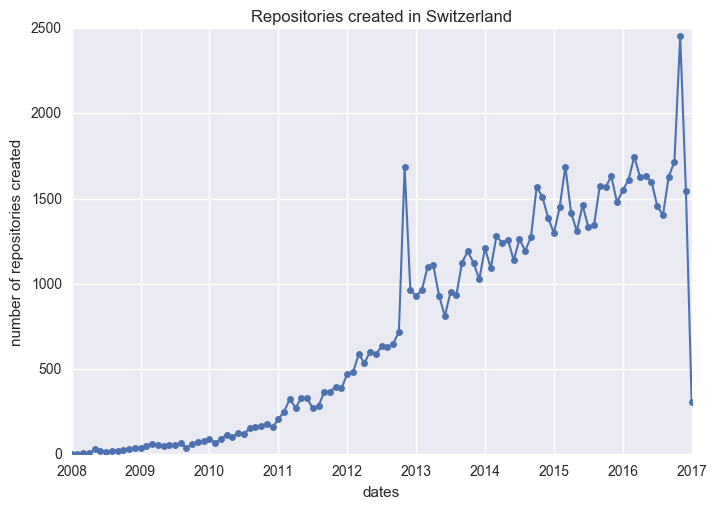

In [26]:
temp = form_ts(repos_informations)
temp = pd.Series(index=temp.index).fillna(1)
ax = temp.resample('M').count().plot(lw=1.5,  marker='.',markersize=10, title = 'Repositories created in Switzerland')
ax.set_xlabel("dates")
ax.set_ylabel("number of repositories created")


We can also see the evolution of the number of repositories created by community as a function of time. We note an increasing trend, explained by the communities growing over time.

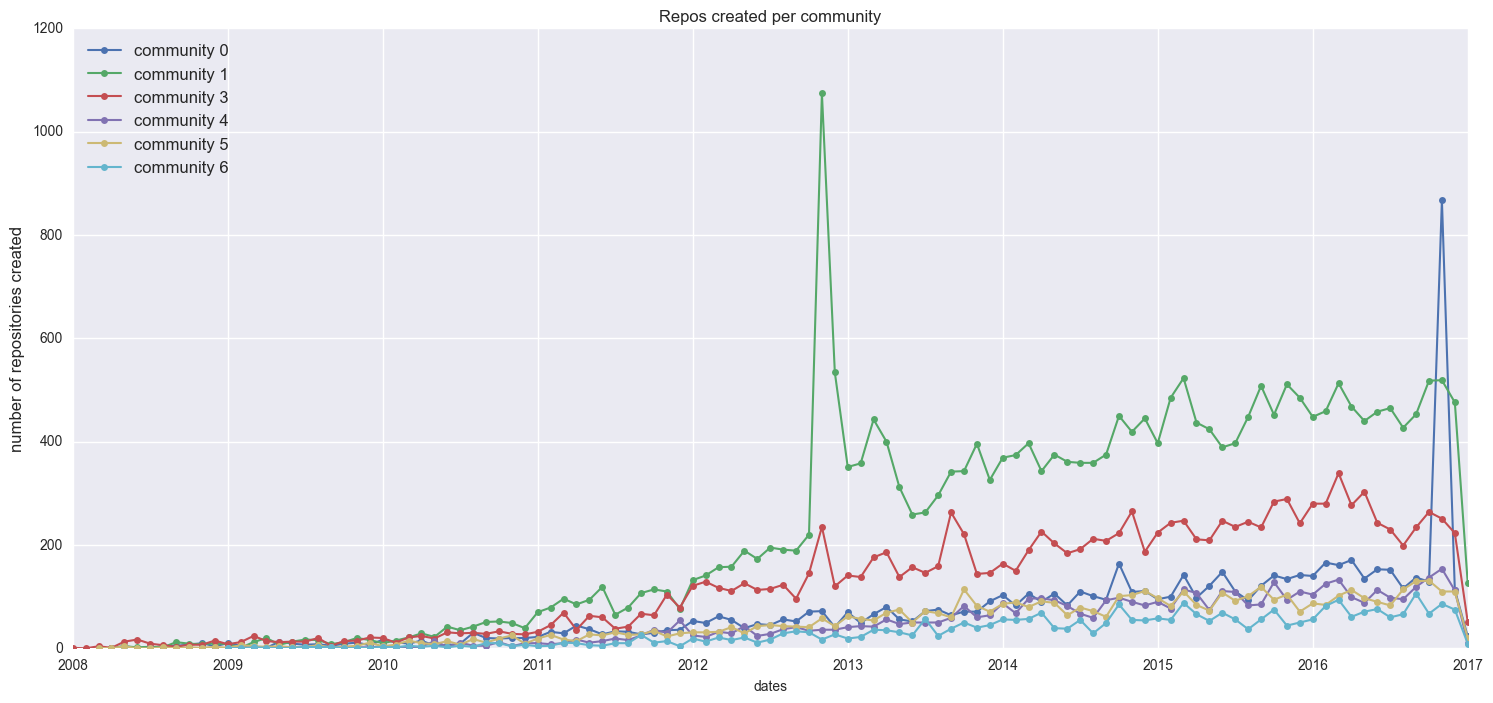

In [27]:
test = form_ts(repos_informations)
plt.figure(figsize=(18,8))
ax = test[test['community']==0].community.resample('M').count().plot(lw=1.5,marker='.',markersize=10,title=('Repos created per community'), label = 'community 0')

for i in [1,3,4,5,6] : 
    test[test['community']==i].community.resample('M').count().plot(ax=ax, lw=1.5,  marker='.',markersize=10, label = 'community ' + str(i))

ax.legend(loc='upper left', shadow=True)
plt.legend(loc=2,prop={'size':12})
plt.xlabel('dates', fontsize=10)
plt.ylabel('number of repositories created', fontsize=12)
plt.rcParams.update({'font.size': 10})
plt.show()

The graphs shown bellow expose that community 1 is the most active. Moreover, we can notice huge peaks in repositories created by the communities 0 and 1 at the of end year 2012 and 2016 respectively. Consequently, we inspect if the dataframe section over these time ranges contain anomalies.

In [57]:
df_nov = test[test['community']==1]['11-1-2012':'11-30-2012']
df_nov[['community','login','forks_count']].groupby('login').sum().sort_values('community',axis=0, ascending=False).head(15)

,community,forks_count
login,,
alepharchives,814,3
adrian-bl-hox-jb,13,11
ReneNyffenegger,11,0
adoweb,8,0
sdolgy,7,0
zpartakov,6,4
tpruvot,6,4
jmelett,5,0
mpenet,5,2


We figure out that an unique login 'AlephArchives' has 814 repos during November 2012. We double check our finding on the Github webite. A quick web search show us that the Github account belongs to a professional firm providing 'Secure Web Archive Solution'. Therefore, we have demonstrated that this outlier did not come from an error in the data-retrieval or in the data-processing.

<img src="image1.png">

We repeat the same approach for the second outlier case in community 1. We found out that a single super productive user created approximately 700 repos in November 2016.

In [39]:
df_nov = test[test['community']==0]['11-1-2016':'11-30-2016']
df_nov['community'] = 1
df_nov[['community','login','forks_count']].groupby('login').sum().sort_values('community',axis=0, ascending=False).head(15)

,community,forks_count
login,,
marcbachmann,733,0
adamralph,6,0
moikorg,5,0
aalmiray,5,0
ruflin,5,0
StreakyCobra,4,1
cansik,4,0
RaoOfPhysics,4,0
falti,4,0


<img src="image2.png">

We can explore the most used programming languages of the repositories created. We decide to focus on the two most populated communities for our analysis to have more insighfull visualizations.

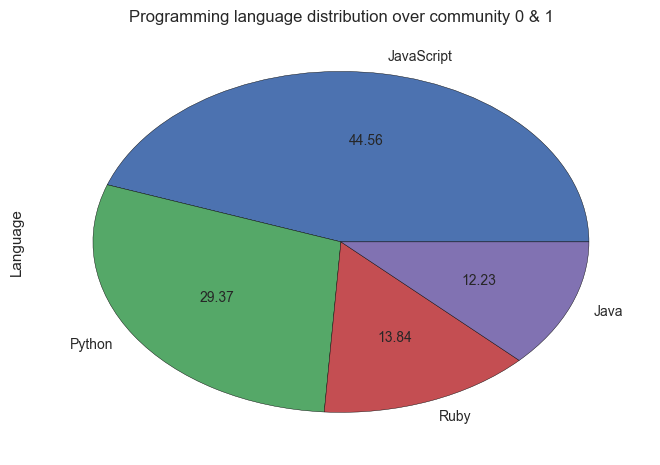

In [55]:
lan_count = test[(test['community']==0 & (test['community']==1))].Language.value_counts()
lan_count[0:4].plot.pie(autopct='%.2f',title='Programming language distribution over community 0 & 1')

The pie plot shows us that 'JavaScript' and 'Python' are the most used language in community 0 and 1. It is interesting to observe the popularity of these languages over the time. Morevover, it can demonstrates which of them contribute the most to the evolution of communities.

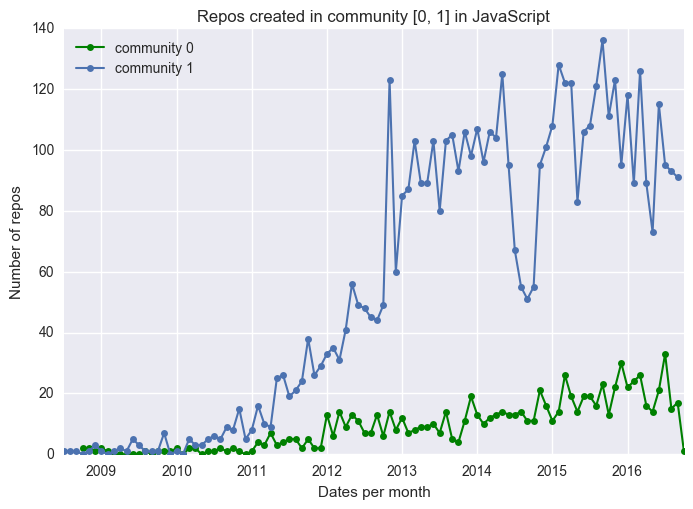

In [42]:
show_repos_lan(test[:'10-1-2016'],[0,1],'M','JavaScript')


We can notice that community 1 creates more repos than community 0 in JavaScript. Moreover, the curve of the latter shows a big variance this last 5 years and is rather exponential than linear.

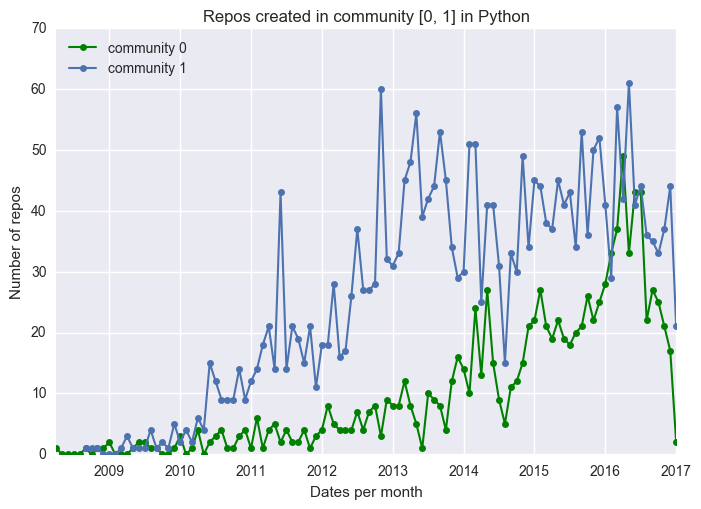

In [84]:
show_repos_lan(test,[0,1],'M','Python')

In Python, both communities show a big variances in their creation of repos. However, they keep increasing greatly over the years assuming that the high decrease near end of year 2017 is due to the limitaion of our data-retrieval.

Finally, we plot an aggregation of the repos created by all communities over the time.

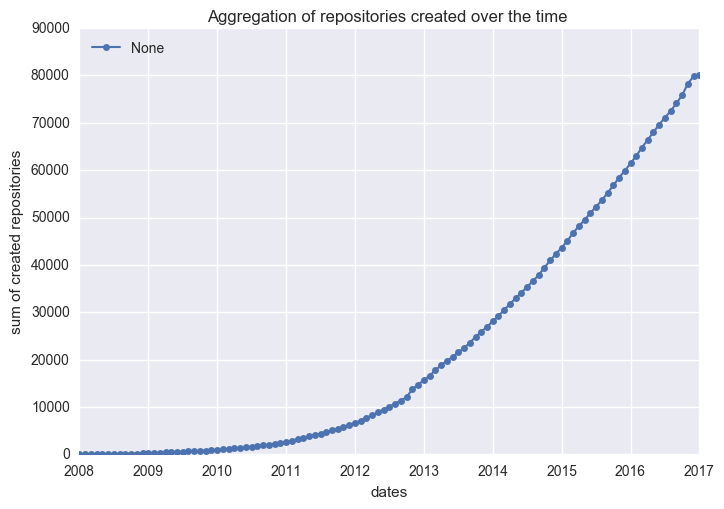

In [114]:
plot_cumulative()

We can observe an exponential growth of repos created over the years per Github Swiss users. It demonstrates that the Swiss community of programmer evolves greatly over the time. 

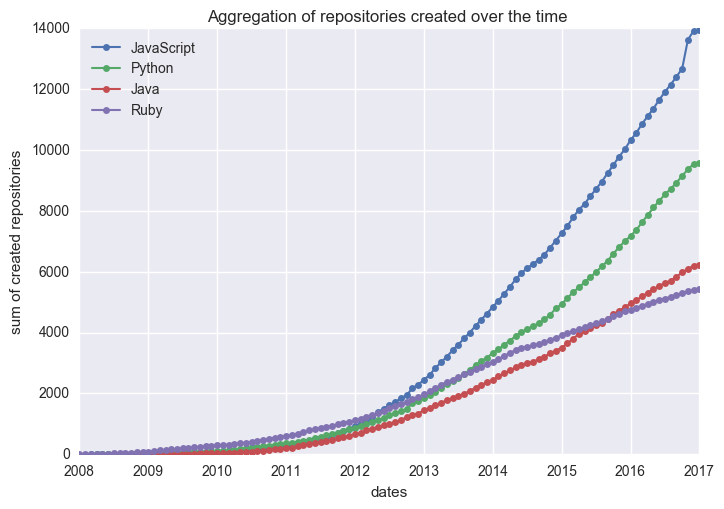

In [43]:
plot_cumulative(language='JavaScript')
plot_cumulative(language='Python')
plot_cumulative(language='Java')
plot_cumulative(language='Ruby')


As we can observe in this last figure, JavaScript has the best growth in the total number of repos created over the time.